In [ ]:
#Importing Required Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Load the dataset
df = pd.read_csv('players_data.csv')
df.head()


,userNum,nickname,gameId,seasonId,gameRank,character,weapon,itemWeapon,itemChest,itemHead,...,Trait_Main1,Trait_Main2,Trait_Sub1,Trait_Sub2,TeamKill,Kill,Death,Assist,Dmg_Player,Dmg_Monster
0,5426009,마샤,46678118,31,2,Cathy,Dagger,Asura,The_Revenant,Imperial_Crown,...,Unwavering_Mentality,Cavalcade,Coin_Toss,Penny_Pincher,5,0,3,5,12065,53392
1,5296453,쿠로미여동생,46678118,31,1,Hisui,Two-handed_Sword,Aurora_Longsword,Áo_Dài,Blaster_Helmet,...,Contempt_for_the_Weak,Anima_Reaper,Unwavering_Mentality,Cavalcade,17,5,4,7,15397,79563
2,5162955,우주생명마음,46678118,31,5,Adina,Arcana,The_Moon,Blood_Cloak,Persona,...,Open_Wounds,Overwatch,Dismantle_Goliath,Anima_Reaper,19,12,2,6,36449,67664
3,5140049,只玩过卡拉彼丘,46678118,31,7,Ly Anh,Dagger,Maharaja,Dragon_Dobok,Cowboy_Hat,...,Frenzy,Carnivore,Painkiller,Dine_n'_Dash,10,0,3,6,6315,23338
4,5051669,초고교급마다키,46678118,31,7,Tsubame,Shuriken,Petal_Torrent,Changpao,Crystal_Tiara,...,Dismantle_Goliath,Anima_Reaper,Unwavering_Mentality,Cavalcade,10,9,2,0,17556,50226


In [ ]:
#Check how many rows have any missing trait values
trait_cols = ['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']

#Count rows with any missing trait
missing_trait_rows = df[trait_cols].isnull().any(axis=1).sum()

#Count total rows before dropping
total_rows_before = len(df)

#Calculate filled vs missing trait ratios
print(f"Total rows before dropping: {total_rows_before}")
print(f"Rows with missing traits: {missing_trait_rows} ({(missing_trait_rows / total_rows_before):.2%})")
print(f"Rows with all traits filled: {total_rows_before - missing_trait_rows} ({((total_rows_before - missing_trait_rows) / total_rows_before):.2%})")


Total rows before dropping: 311265
Rows with missing traits: 41064 (13.19%)
Rows with all traits filled: 270201 (86.81%)


In [12]:
#Handle missing values
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print("Missing values (top 10):\n", missing_ratio.head(10))

#Drop rows where key performance metrics are missing
df.dropna(subset=['gameRank', 'Dmg_Player', 'Dmg_Monster','Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2'], inplace=True)


Missing values (top 10):
 Trait_Main2    0.131926
Trait_Main1    0.131926
Trait_Sub2     0.001645
Trait_Sub1     0.000469
nickname       0.000026
userNum        0.000000
Dmg_Player     0.000000
Assist         0.000000
Death          0.000000
Kill           0.000000
dtype: float64


In [ ]:
#Feature Engineering (fixed)

#combine the traits into one string
df['AllTraits'] = df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']].agg('_'.join, axis=1)

#Bin gameRank into performance tiers
def rank_to_tier(rank):
    if rank <= 3:
        return 'Good'
    elif rank <= 6:
        return 'Average'
    else:
        return 'Bad'

df['BuildPerformance'] = df['gameRank'].apply(rank_to_tier)


In [ ]:
#Define input features and target

#Features we'll use:
categorical_features = ['character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead', 'itemArm', 'itemLeg', 'AllTraits']
numerical_features = ['Kill', 'Assist', 'Death', 'TeamKill', 'Dmg_Player', 'Dmg_Monster']

#Target: BuildPerformance (Good/Average/Bad)
target = 'BuildPerformance'


In [15]:
#Split dataset
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
#Build Preprocessing Pipeline

#Categorical pipeline: Fill missing with 'Unknown', then one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#Numerical pipeline: Fill missing with median, then scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])


In [ ]:
#Dictionary of models to evaluate
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

#This dictionary will hold the evaluation results for each model
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    # Define pipeline with the preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    #Perform cross-validation to evaluate the model
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False
    )
    
    #Store the results for the current model
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

#Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

#Split the means and standard deviations into separate columns for each metric
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)

#Drop the original columns containing tuples
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])

#Display the final result
print(results_df)


In [17]:
#Final pipeline with classifier

model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [18]:
#Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'AllTraits']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Kill', 'Assist', 'Death',
                                                   'TeamKill', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Classification Report:

              precision    recall  f1-score   support

     Average       0.67      0.73      0.70     20820
         Bad       0.78      0.68      0.72     11782
        Good       0.83      0.83      0.83     21439

    accuracy                           0.76     54041
   macro avg       0.76      0.74      0.75     54041
weighted avg       0.76      0.76      0.76     54041

Confusion Matrix:



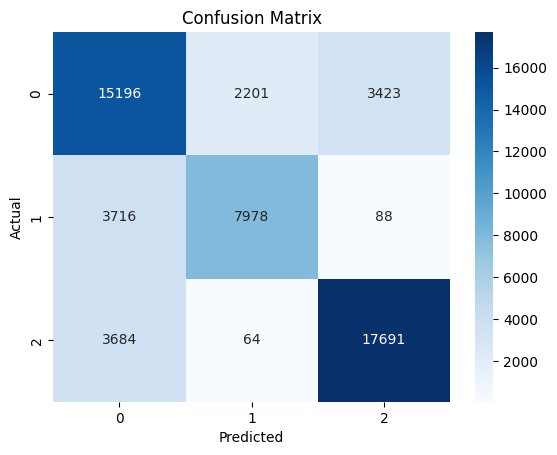

In [19]:
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [20]:
def get_recommended_build(character_name, top_n=1, display=True):

    char_data = df[df['character'] == character_name]

    if char_data.empty:
        print(f"No data found for character: {character_name}")
        return []

    top_builds = char_data[char_data['gameRank'] <= 3]

    if top_builds.empty:
        print(f"No high-performing builds found for {character_name}. Showing best available instead.")
        top_builds = char_data.sort_values(by='gameRank', ascending=True).head(top_n)
    else:
        top_builds = top_builds.sort_values(by='gameRank', ascending=True).head(top_n)

    builds = []
    for idx, (_, row) in enumerate(top_builds.iterrows(), start=1):
        build = {
            "ItemWeapon": row['itemWeapon'],
            "ItemChest": row['itemChest'],
            "ItemHead": row['itemHead'],
            "ItemArm": row['itemArm'],
            "ItemLeg": row['itemLeg'],
            "Traits": [row['Trait_Main1'], row['Trait_Main2'], row['Trait_Sub1'], row['Trait_Sub2']]
        }
        builds.append(build)

        if display:
            print(f"\nRecommended Build #{idx} for {character_name}:")
            print(f"ItemWeapon  : {build['ItemWeapon']}")
            print(f"ItemChest   : {build['ItemChest']}")
            print(f"ItemHead    : {build['ItemHead']}")
            print(f"ItemArm     : {build['ItemArm']}")
            print(f"ItemLeg     : {build['ItemLeg']}")
            print("Traits      : " + ", ".join(build['Traits']))


In [28]:
get_recommended_build("Hisui", top_n=3)



Recommended Build #1 for Hisui:
ItemWeapon  : Aurora_Longsword
ItemChest   : Áo_Dài
ItemHead    : Blaster_Helmet
ItemArm     : Mythril_Quiver
ItemLeg     : Blade_Boots
Traits      : Contempt_for_the_Weak, Anima_Reaper, Unwavering_Mentality, Cavalcade

Recommended Build #2 for Hisui:
ItemWeapon  : Aurora_Longsword
ItemChest   : Áo_Dài
ItemHead    : Blaster_Helmet
ItemArm     : Plasma_Arc
ItemLeg     : White_Rhinos
Traits      : Contempt_for_the_Weak, Anima_Reaper, Unwavering_Mentality, Cavalcade

Recommended Build #3 for Hisui:
ItemWeapon  : Dáinsleif
ItemChest   : Áo_Dài
ItemHead    : Blaster_Helmet
ItemArm     : Auto-arms
ItemLeg     : Blade_Boots
Traits      : Contempt_for_the_Weak, Anima_Reaper, Unwavering_Mentality, Cavalcade
